In [1]:
# -----------------------------------------------
# 1. IMPORT all required libraries
# -----------------------------------------------
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# -----------------------------------------------
# 2. LOAD Banking data downloaded from UCI 
# -----------------------------------------------
df = pd.read_csv("bank.csv") 



In [3]:
# 3. IDENTIFY TARGET COLUMN (Deposit)
# ---------------------------------------------------------
# Case-insensitive match for safety
target_candidates = [col for col in df.columns if "deposit" in col.lower()]

if len(target_candidates) == 0:
    raise ValueError("No target column found. Check the file CSV header.")

target = target_candidates[0]
print("Using target column:", target)

Using target column: Deposit


In [4]:
# ---------------------------------------------------------
# 4. ENCODE CATEGORICAL VARIABLES
# ---------------------------------------------------------
df_encoded = pd.get_dummies(df, drop_first=True)

# After encoding, target becomes Deposit_yes (if categorical)
target_encoded = [col for col in df_encoded.columns if col.lower().startswith(target.lower())][0]

print("Encoded target column:", target_encoded)

X = df_encoded.drop(target_encoded, axis=1)
y = df_encoded[target_encoded]

Encoded target column: Deposit_yes


In [5]:
# ---------------------------------------------------------
# 5. TRAIN-TEST SPLIT with 0.8/0.2 ratio
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
# ---------------------------------------------------------
# 6. SCALING (for LR, SVM, KNN)
# ---------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# ---------------------------------------------------------
# 7. DEFINE MODELS
# ---------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes (Gaussian)": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(
        eval_metric='logloss'
    )
}



Training Model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.97      0.95      7985
        True       0.65      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



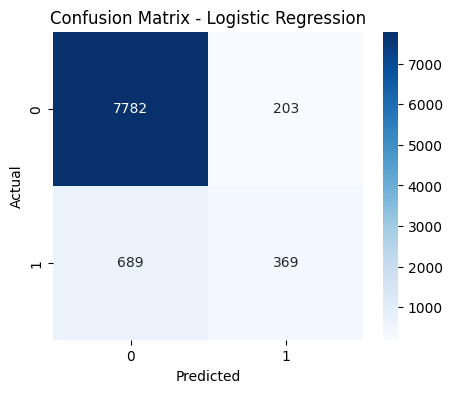



Training Model: Decision Tree

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.93      0.93      7985
        True       0.46      0.48      0.47      1058

    accuracy                           0.87      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.88      0.87      0.88      9043



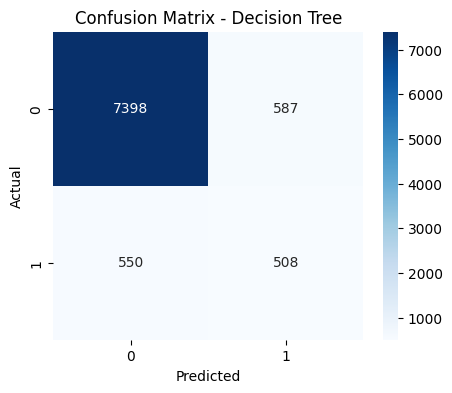



Training Model: KNN

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.97      0.94      7985
        True       0.59      0.31      0.40      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.64      0.67      9043
weighted avg       0.88      0.89      0.88      9043



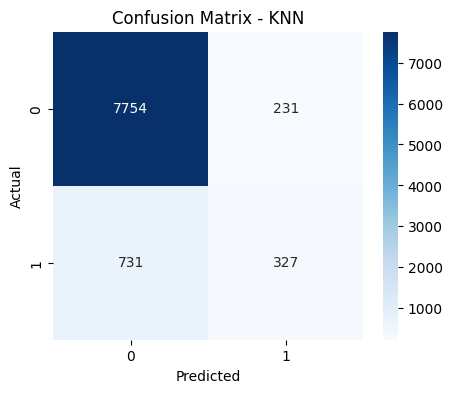



Training Model: Naive Bayes (Gaussian)

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.91      0.92      7985
        True       0.43      0.52      0.47      1058

    accuracy                           0.86      9043
   macro avg       0.68      0.71      0.70      9043
weighted avg       0.88      0.86      0.87      9043



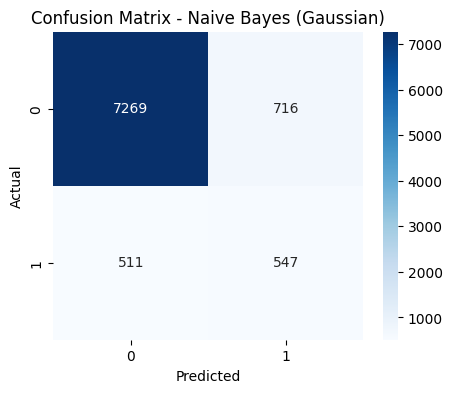



Training Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.97      0.95      7985
        True       0.68      0.40      0.50      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.69      0.73      9043
weighted avg       0.90      0.91      0.90      9043



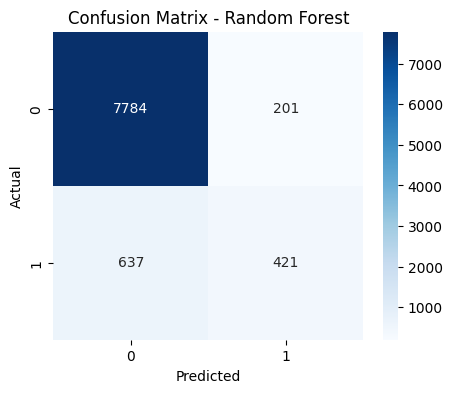



Training Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.96      0.95      7985
        True       0.63      0.50      0.56      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.73      0.75      9043
weighted avg       0.90      0.91      0.90      9043



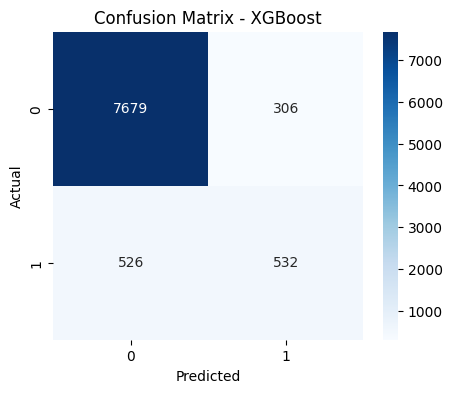

In [8]:
# ---------------------------------------------------------
# 8. TRAIN, PREDICT & EVALUATE
# ---------------------------------------------------------
results = []

for name, model in models.items():
    print("\n")
    print("="*100)
    print(f"Training Model: {name}")
    print("="*100)

    # Use scaled data for LR, KNN
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    # Capture all Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    results.append([name, accuracy, auc, precision, recall, f1, mcc])

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [9]:
# ---------------------------------------------------------
# 9. Comparison of all metrics across all models
# ---------------------------------------------------------
results_df = pd.DataFrame(
    results,
    columns=[
        "Model", "Accuracy", "AUC Score", "Precision",
        "Recall", "F1 Score", "MCC Score"
    ]
)

print("\n\n===== MODEL COMPARISON TABLE Sorted by descending AUC score =====\n")
print(results_df.sort_values(by="AUC Score", ascending=False))



===== MODEL COMPARISON TABLE Sorted by descending AUC score =====

                    Model  Accuracy  AUC Score  Precision    Recall  F1 Score  \
5                 XGBoost  0.907995   0.929058   0.634845  0.502836  0.561181   
4           Random Forest  0.907332   0.928071   0.676849  0.397921  0.501190   
0     Logistic Regression  0.901360   0.905499   0.645105  0.348771  0.452761   
3  Naive Bayes (Gaussian)  0.864315   0.823126   0.433096  0.517013  0.471349   
2                     KNN  0.893619   0.808369   0.586022  0.309074  0.404703   
1           Decision Tree  0.874267   0.703319   0.463927  0.480151  0.471900   

   MCC Score  
5   0.514894  
4   0.473390  
0   0.426959  
3   0.396248  
2   0.374213  
1   0.400639  
